<a href="https://colab.research.google.com/github/a1869470/Deep_Learning/blob/main/DL_Assessment_3_(RNN_Prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
4/4 [==============================] - 0s 8ms/step
Simple RNN Mean Squared Error for Next Day Price Ratio Prediction: 0.005345508648840157


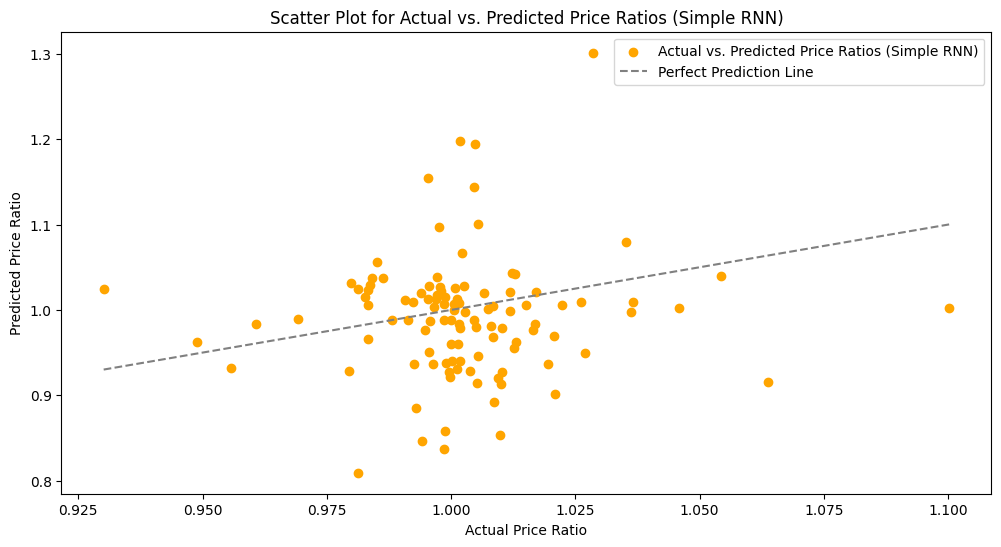

Simple RNN Final Training Loss: 0.020620964467525482
Simple RNN Final Validation Loss: 0.005756261758506298


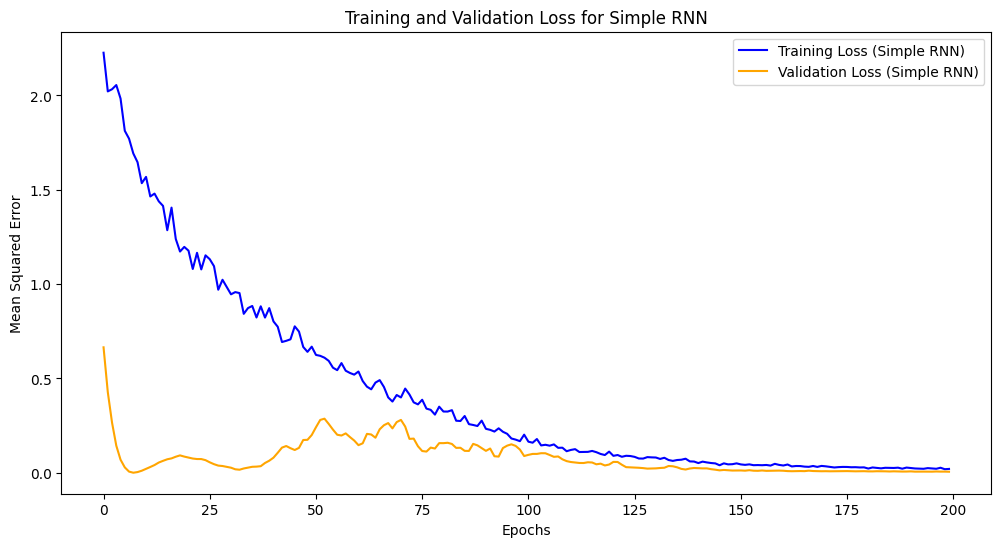

4/4 [==============================] - 1s 14ms/step
LSTM Mean Squared Error for Next Day Price Ratio Prediction: 0.0007650938079126639


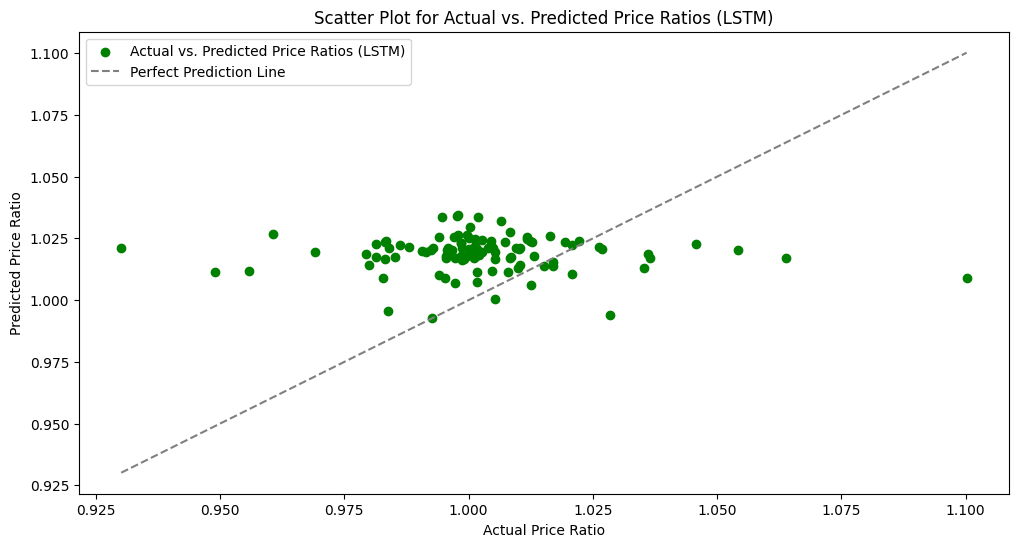

LSTM Final Training Loss: 0.01151340827345848
LSTM Final Validation Loss: 0.0008150805369950831


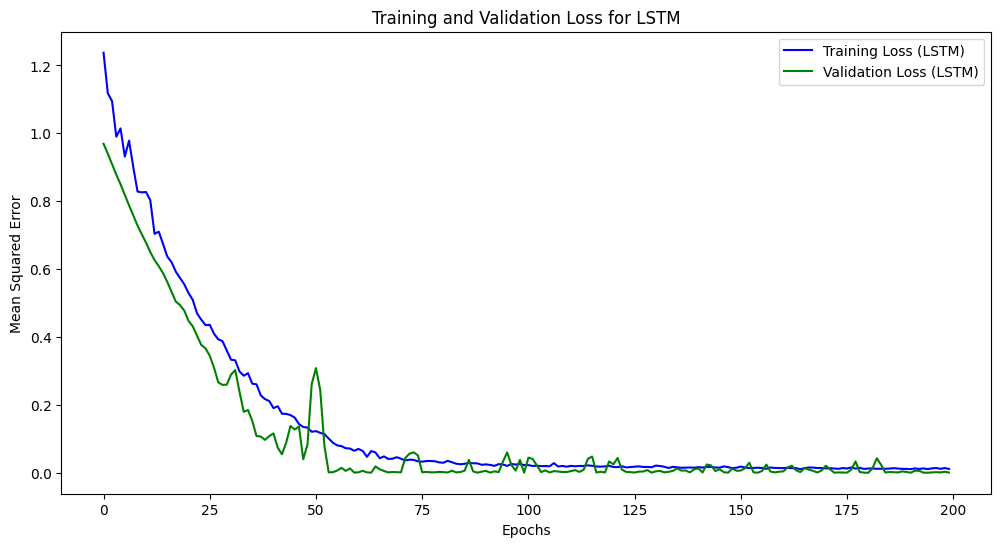

4/4 [==============================] - 1s 9ms/step
GRU Mean Squared Error for Next Day Price Ratio Prediction: 0.12762758884634998


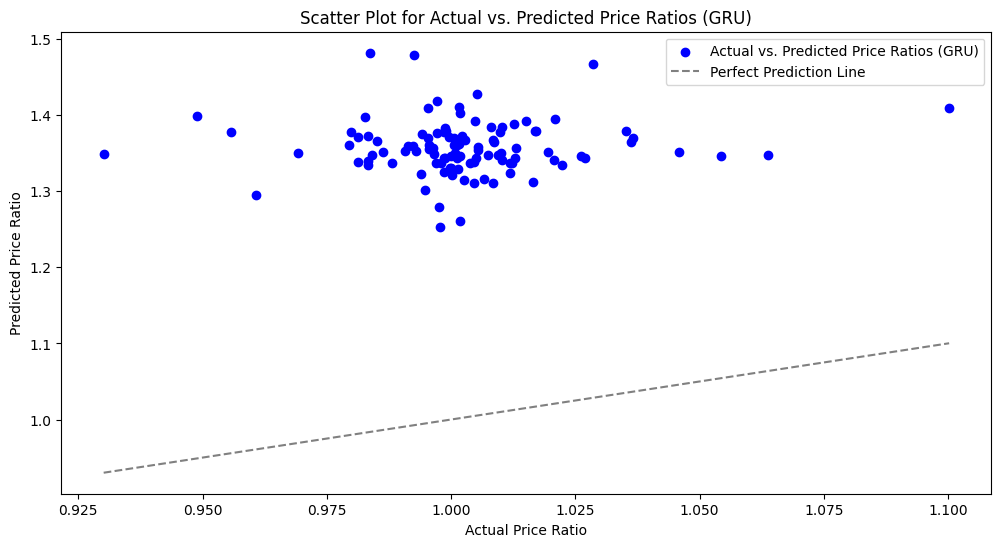

GRU Final Training Loss: 0.04119834676384926
GRU Final Validation Loss: 0.12259541451931


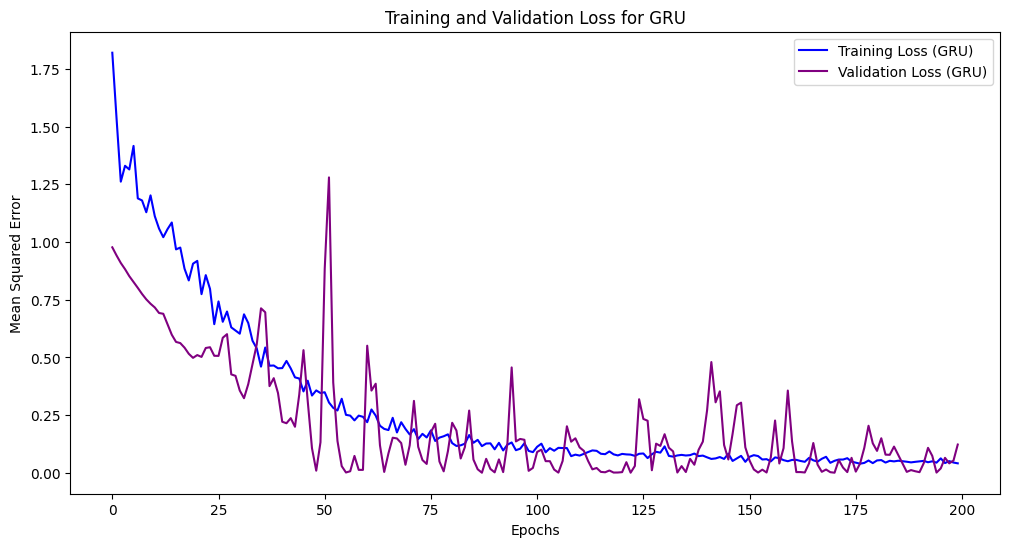

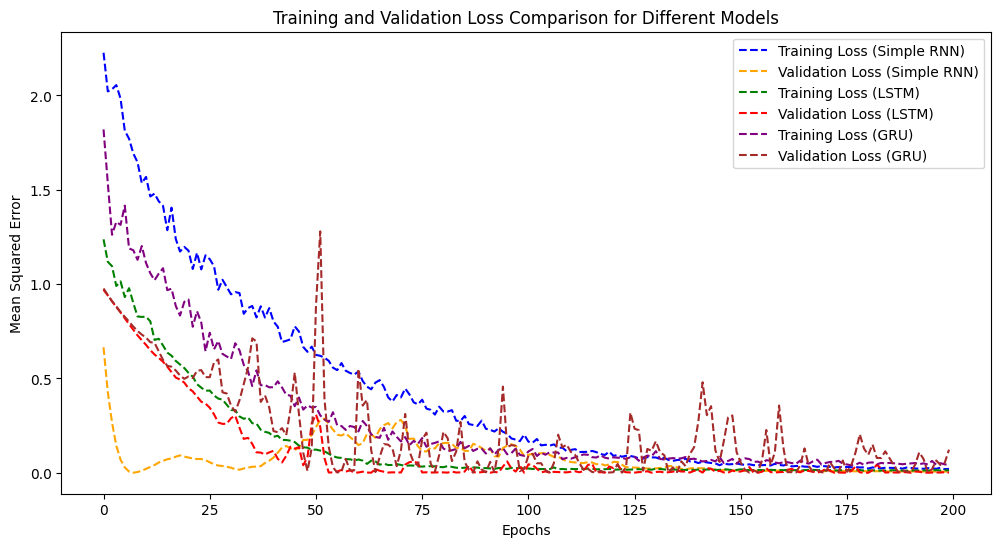

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Mean Squared Error for Next Day Prices: 0.0007718037297419242


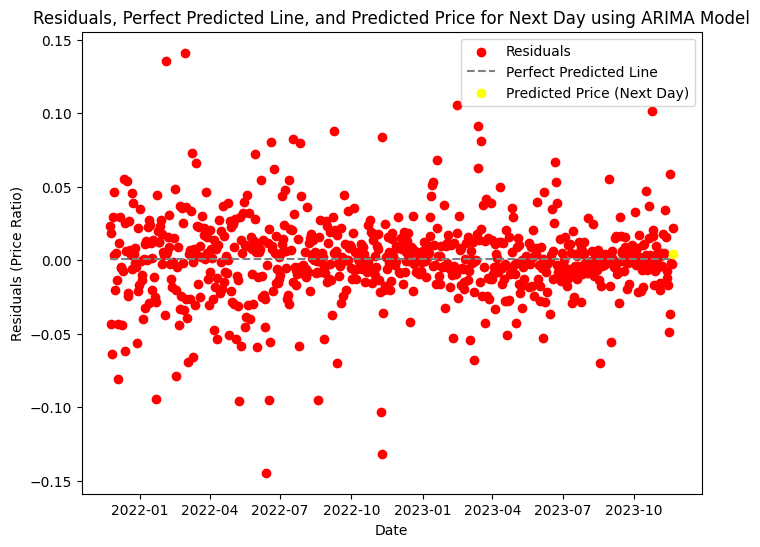

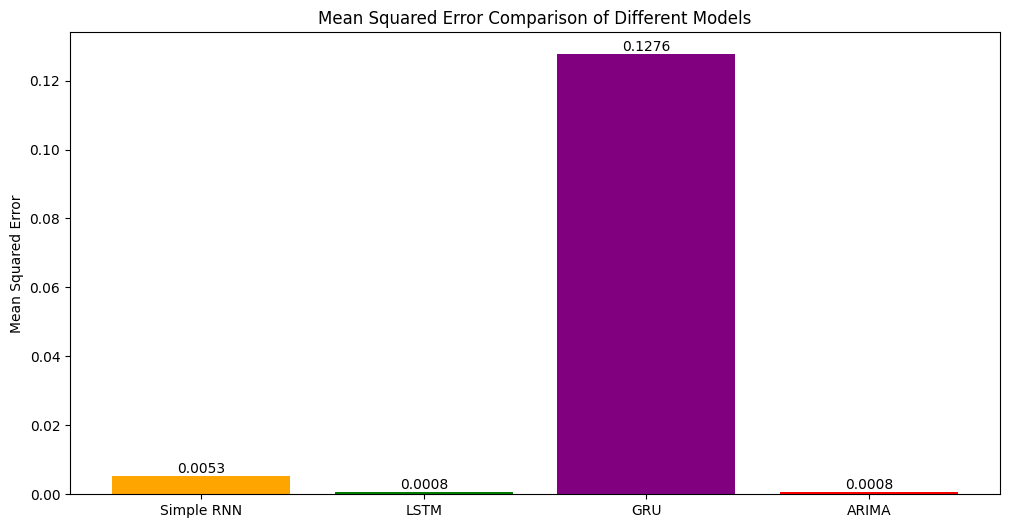

In [11]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, GRU, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA

# Fetch historical stock data (e.g., Bitcoin in AUD - 'BTC-AUD')
stock_data = yf.download('BTC-AUD', period='2y')

# Compute daily residuals
stock_data['Residuals'] = stock_data['Adj Close'].pct_change()
stock_data.dropna(inplace=True)

# Create the target variable representing the actual percentage change in price for the next day
stock_data['Next_Day_Price_Ratio'] = stock_data['Adj Close'].pct_change().shift(-1) + 1

# Use past 20 days to predict the actual price change next day
lookback_days = 20

X, y = [], []
for i in range(len(stock_data) - lookback_days - 1):
    X.append(stock_data['Residuals'].values[i:i + lookback_days])
    y.append(stock_data['Next_Day_Price_Ratio'].values[i + lookback_days])

X = np.array(X)
y = np.array(y)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Adjusted threshold for regression
threshold = 0.01  # Adjust as needed

# Reshape data for LSTM input [samples, time steps, features]
X_train_rnn = np.reshape(X_train, (X_train.shape[0], lookback_days, 1))
X_val_rnn = np.reshape(X_val, (X_val.shape[0], lookback_days, 1))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], lookback_days, 1))

# Build and compile the Simple RNN model for regression
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))
model_rnn.add(BatchNormalization())
model_rnn.add(SimpleRNN(25, activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(1, activation='linear'))  # Use linear activation for regression
optimizer_rnn = Adam(learning_rate=0.0001)
model_rnn.compile(optimizer=optimizer_rnn, loss='mean_squared_error', metrics=['mse'])

# Train the Simple RNN model for regression
history_rnn = model_rnn.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_val_rnn, y_val), verbose=0)

# Evaluate and print mean squared error for Simple RNN
predicted_prices_rnn = model_rnn.predict(X_test_rnn)
mse_rnn = np.mean((predicted_prices_rnn.flatten() - y_test[:len(predicted_prices_rnn)])**2)
print(f'Simple RNN Mean Squared Error for Next Day Price Ratio Prediction: {mse_rnn}')

# Scatter plot for Simple RNN
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:len(predicted_prices_rnn)], predicted_prices_rnn.flatten(), color='orange', label='Actual vs. Predicted Price Ratios (Simple RNN)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', label='Perfect Prediction Line')
plt.xlabel('Actual Price Ratio')
plt.ylabel('Predicted Price Ratio')
plt.title('Scatter Plot for Actual vs. Predicted Price Ratios (Simple RNN)')
plt.legend()
plt.show()

# Print final training and validation loss for Simple RNN
final_train_loss_rnn = history_rnn.history['loss'][-1]
final_val_loss_rnn = history_rnn.history['val_loss'][-1]
print(f'Simple RNN Final Training Loss: {final_train_loss_rnn}')
print(f'Simple RNN Final Validation Loss: {final_val_loss_rnn}')

# Plot training and validation loss for Simple RNN
plt.figure(figsize=(12, 6))
plt.plot(history_rnn.history['loss'], label='Training Loss (Simple RNN)', color='blue')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss (Simple RNN)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss for Simple RNN')
plt.legend()
plt.show()


# Update the LSTM model with dropout
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='linear'))
optimizer_lstm = Adam(learning_rate=0.0001)  # Adjust learning rate
model_lstm.compile(optimizer=optimizer_lstm, loss='mean_squared_error', metrics=['mse'])




# Train the LSTM model for more epochs
history_lstm = model_lstm.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_val_rnn, y_val), verbose=0)


# Evaluate and print mean squared error for LSTM
predicted_prices_lstm = model_lstm.predict(X_test_rnn)
mse_lstm = np.mean((predicted_prices_lstm.flatten() - y_test[:len(predicted_prices_lstm)])**2)
print(f'LSTM Mean Squared Error for Next Day Price Ratio Prediction: {mse_lstm}')

# Scatter plot for LSTM
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:len(predicted_prices_lstm)], predicted_prices_lstm.flatten(), color='green', label='Actual vs. Predicted Price Ratios (LSTM)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', label='Perfect Prediction Line')
plt.xlabel('Actual Price Ratio')
plt.ylabel('Predicted Price Ratio')
plt.title('Scatter Plot for Actual vs. Predicted Price Ratios (LSTM)')
plt.legend()
plt.show()

# Print final training and validation loss for LSTM
final_train_loss_lstm = history_lstm.history['loss'][-1]
final_val_loss_lstm = history_lstm.history['val_loss'][-1]
print(f'LSTM Final Training Loss: {final_train_loss_lstm}')
print(f'LSTM Final Validation Loss: {final_val_loss_lstm}')

# Plot training and validation loss for LSTM
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss for LSTM')
plt.legend()
plt.show()



# Build and compile a GRU model for regression
model_gru = Sequential()
model_gru.add(GRU(100, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3))
model_gru.add(GRU(50, return_sequences=False))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='linear'))
optimizer_gru = Adam(learning_rate=0.0001)  # Adjust learning rate
model_gru.compile(optimizer=optimizer_gru, loss='mean_squared_error', metrics=['mse'])

# Train the GRU model for regression
history_gru = model_gru.fit(X_train_rnn, y_train, epochs=200, batch_size=32, validation_data=(X_val_rnn, y_val), verbose=0)

# Evaluate and print mean squared error for GRU
predicted_prices_gru = model_gru.predict(X_test_rnn)
mse_gru = np.mean((predicted_prices_gru.flatten() - y_test[:len(predicted_prices_gru)])**2)
print(f'GRU Mean Squared Error for Next Day Price Ratio Prediction: {mse_gru}')

# Scatter plot for GRU
plt.figure(figsize=(12, 6))
plt.scatter(y_test[:len(predicted_prices_gru)], predicted_prices_gru.flatten(), color='blue', label='Actual vs. Predicted Price Ratios (GRU)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', label='Perfect Prediction Line')
plt.xlabel('Actual Price Ratio')
plt.ylabel('Predicted Price Ratio')
plt.title('Scatter Plot for Actual vs. Predicted Price Ratios (GRU)')
plt.legend()
plt.show()

# Print final training and validation loss for GRU
final_train_loss_gru = history_gru.history['loss'][-1]
final_val_loss_gru = history_gru.history['val_loss'][-1]
print(f'GRU Final Training Loss: {final_train_loss_gru}')
print(f'GRU Final Validation Loss: {final_val_loss_gru}')

# Plot training and validation loss for GRU
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Training Loss (GRU)', color='blue')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss for GRU')
plt.legend()
plt.show()

# Compare training and validation loss for all models
plt.figure(figsize=(12, 6))

# Simple RNN
plt.plot(history_rnn.history['loss'], label='Training Loss (Simple RNN)', color='blue', linestyle='dashed')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss (Simple RNN)', color='orange', linestyle='dashed')

# LSTM
plt.plot(history_lstm.history['loss'], label='Training Loss (LSTM)', color='green', linestyle='dashed')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red', linestyle='dashed')

# GRU
plt.plot(history_gru.history['loss'], label='Training Loss (GRU)', color='purple', linestyle='dashed')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='brown', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss Comparison for Different Models')
plt.legend()
plt.show()


# Compute daily price ratios
stock_data['Price_Ratio'] = stock_data['Adj Close'].pct_change()
stock_data.dropna(inplace=True)

# ARIMA Model
order = (5, 1, 5)  # Example order, you may need to tune this
model_arima = ARIMA(stock_data['Price_Ratio'], order=order)
results_arima = model_arima.fit()

# Forecast using ARIMA for the next day
forecast_steps = 1
forecast_index = pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_arima = pd.Series(results_arima.forecast(steps=forecast_steps)[0], index=forecast_index)

# Calculate residuals (difference between actual and predicted)
residuals = stock_data['Price_Ratio'] - results_arima.fittedvalues

# Calculate mean squared error
mse_arima = (residuals ** 2).mean()
print(f'ARIMA Mean Squared Error for Next Day Prices: {mse_arima}')

# Create a perfect predicted line (horizontal line at the mean of residuals)
perfect_predicted_line = pd.Series([residuals.mean()] * len(stock_data), index=stock_data.index)

# Plot the residuals, perfect predicted line, and the predicted price for the next day
plt.figure(figsize=(8, 6))

# Plot the residuals
plt.scatter(stock_data.index, residuals, label='Residuals', color='red')

# Plot the perfect predicted line
plt.plot(stock_data.index, perfect_predicted_line, label='Perfect Predicted Line', linestyle='dashed', color='gray')

# Plot the predicted price for the next day
plt.scatter(forecast_index, forecast_arima, label='Predicted Price (Next Day)', color='yellow')

# plt.axhline(0, color='black', linestyle='--', linewidth=2)  # Add a horizontal line at y=0 for reference
plt.xlabel('Date')
plt.ylabel('Residuals (Price Ratio)')
plt.title('Residuals, Perfect Predicted Line, and Predicted Price for Next Day using ARIMA Model')
plt.legend()
plt.show()


# Compare mean squared error of all models
model_mses = {
    'Simple RNN': mse_rnn,
    'LSTM': mse_lstm,
    'GRU': mse_gru,
    'ARIMA': mse_arima
}

# Plot the mean squared error comparison
plt.figure(figsize=(12, 6))
plt.bar(model_mses.keys(), model_mses.values(), color=['orange', 'green', 'purple', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error Comparison of Different Models')

# Annotate the bars with the corresponding values
for model, mse in model_mses.items():
    plt.text(model, mse, f'{mse:.4f}', ha='center', va='bottom')

plt.show()
